#### Week12-Extra Credict
##### Author: Wen-shan,Liu
##### Date: 05/03/2025

# **Intro of Generative Adversarial Network (GAN)**
**- How it works? </br>**

  A Generative Adversarial Network (GAN) consists of two neural networks—the Generator (G) and the Discriminator (D)—that compete in a game-theoretic setup.

  The Generator learns to create realistic-looking data (e.g., images) from random noise. One the other hand, the Discriminator tries to distinguish between real data (from the training set) and fake data (produced by the generator).

  They are trained simultaneously. The generator(G) improves by fooling the discriminator (D). The discriminator(D) improves by detecting fake data.
  

  Generative Adversarial Network (GAN) was invented by Goodfellow in 2014. In his paper[1] mention the whole adversarial training framework in GAN is following two-player minimax game with with value function V (G, D):
  
![CleanShot](https://raw.githubusercontent.com/wenshanliu-slu0/HDS5230/main/Week12/Extra_Credict/CleanShot.jpg)


---


**- How it used?**

GANs are widely applied in areas that involve data generation, especially for tasks that require learning data distributions without labels:

  Image synthesis: e.g., human face generation (StyleGAN)[2].

  Image-to-image translation: e.g., converting summer to winter scenes or photos to paintings (CycleGAN)[3].

  Impuatation missing value: e.g., imputate medical missing value in EHR datasets (ccGAN)[4].



---


**- Any gotchas in using it?**


Training GANs is notoriously difficult and prone to several challenges:

 - Mode collapse: the generator produces limited variety, ignoring parts of the data distribution.

 - Training instability: the balance between G and D is delicate and can lead to divergence.

 - Resource-intensive: GANs require significant computational power and tuning.

 - Hyperparameter sensitivity: results can vary greatly based on architecture and optimizer settings.




---


Reference: </br>
[1] Goodfellow, I., Pouget-Abadie, J., Mirza, M., Xu, B., Warde-Farley, D., Ozair, S., Courville, A., & Bengio, Y. (2017). GAN(Generative Adversarial Nets). Journal of Japan Society for Fuzzy Theory and Intelligent Informatics, 29(5), 177. https://doi.org/10.3156/jsoft.29.5_177_2


[2] Karras, T., Laine, S., & Aila, T. (2019). A Style-Based generator architecture for generative adversarial networks. 2022 IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR). https://doi.org/10.1109/cvpr.2019.00453


[3] Zhu et al. (2017), “Unpaired Image-to-Image Translation with CycleGAN”
https://arxiv.org/abs/1703.10593

[4] Bernardini, M., Doinychko, A., Romeo, L., Frontoni, E., & Amini, M. (2023). A novel missing data imputation approach based on clinical conditional Generative Adversarial Networks applied to EHR datasets. Computers in Biology and Medicine, 163, 107188. https://doi.org/10.1016/j.compbiomed.2023.107188




In [1]:
# Example of GAN by using Pytorch
# In this example, it will demostrate how to implement GAN and generate realistic images.

#step1 : import libraries

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np


# Check running device
# use cuda(gpu) or cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'device is:', device)


device is: cuda


In [2]:
# Step 2: Defining Image Transformations
# To normalize and convert images into tensors before feeding them into the model.

# Define a basic transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), # (mean values of each colors)
                         (0.5, 0.5, 0.5)) # (std for each color channel)
])


In [3]:
# Step 3: Loading the CIFAR-10 Dataset

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(train_dataset,  batch_size=64, shuffle=True)

100%|██████████| 170M/170M [02:06<00:00, 1.35MB/s]


In [4]:
# Step 4: Defining GAN Hyperparameters
# Hyperparameters
latent_dim = 100
lr = 0.0001
beta1 = 0.5  # parameters for the Adam optimizer
beta2 = 0.999 # parameters for the Adam optimize
num_epochs = 100

In [5]:

#Step 5: Building the Generator

# Define the generator
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128 * 8 * 8), # Takes the random noise (latent_dim) and transforms it into a higher-dimension
            nn.ReLU(),   # use non-linearity, allowing the generator to learn complex patterns.
            nn.Unflatten(1, (128, 8, 8)),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128, momentum=0.78),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64, momentum=0.78),
            nn.ReLU(),  # middle layers: nn.Unflatten、nn.Upsample、nn.Conv2d、nn.BatchNorm2d
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Tanh() # output layer
        )

    def forward(self, z):
        img = self.model(z)
        return img

In [6]:
# Step 6: Building the Discriminator


# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Dropout2d(0.25),
        nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Dropout2d(0.25),
        nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Dropout2d(0.25),
        nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Dropout2d(0.25),

    )


    def forward(self, img):
        validity = self.model(img)
        return validity

In [7]:
# Step 7: Initializing GAN Components

# Define the generator and discriminator
# Initialize generator and discriminator
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

# Loss function
#adversarial_loss = nn.BCELoss()
# use WGAN loss fuction to replace BCELoss()
def wasserstein_loss(y_true, y_pred):
    return torch.mean(y_true * y_pred)

# Optimizers
optimizer_G = optim.Adam(generator.parameters()\
                         , lr=lr, betas=(beta1, beta2))
optimizer_D = optim.Adam(discriminator.parameters()\
                         , lr=lr, betas=(beta1, beta2))

Epoch [1/100]                        Batch 100/782 Discriminator Loss: -0.0282 Generator Loss: -0.0179
Epoch [1/100]                        Batch 200/782 Discriminator Loss: 0.0061 Generator Loss: -0.0227
Epoch [1/100]                        Batch 300/782 Discriminator Loss: 0.0318 Generator Loss: -0.0857
Epoch [1/100]                        Batch 400/782 Discriminator Loss: -0.0027 Generator Loss: -0.0131
Epoch [1/100]                        Batch 500/782 Discriminator Loss: -0.0107 Generator Loss: 0.0140
Epoch [1/100]                        Batch 600/782 Discriminator Loss: 0.0007 Generator Loss: -0.0312
Epoch [1/100]                        Batch 700/782 Discriminator Loss: 0.0002 Generator Loss: -0.0063
Epoch [2/100]                        Batch 100/782 Discriminator Loss: -0.0063 Generator Loss: -0.0125
Epoch [2/100]                        Batch 200/782 Discriminator Loss: 0.0184 Generator Loss: -0.0372
Epoch [2/100]                        Batch 300/782 Discriminator Loss: -0.0854 

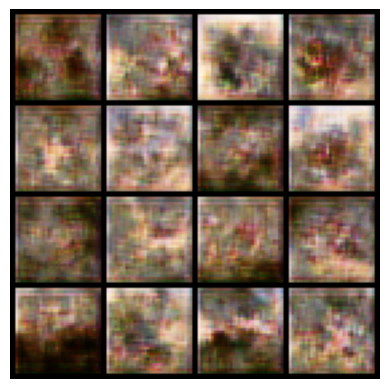

Epoch [11/100]                        Batch 100/782 Discriminator Loss: -0.0025 Generator Loss: 0.0126
Epoch [11/100]                        Batch 200/782 Discriminator Loss: -0.0006 Generator Loss: -0.0106
Epoch [11/100]                        Batch 300/782 Discriminator Loss: -0.0038 Generator Loss: 0.0208
Epoch [11/100]                        Batch 400/782 Discriminator Loss: 0.0046 Generator Loss: 0.0031
Epoch [11/100]                        Batch 500/782 Discriminator Loss: -0.0007 Generator Loss: 0.0405
Epoch [11/100]                        Batch 600/782 Discriminator Loss: -0.0018 Generator Loss: -0.0552
Epoch [11/100]                        Batch 700/782 Discriminator Loss: -0.1006 Generator Loss: 0.1093
Epoch [12/100]                        Batch 100/782 Discriminator Loss: -0.0250 Generator Loss: 0.1274
Epoch [12/100]                        Batch 200/782 Discriminator Loss: -0.0139 Generator Loss: 0.0151
Epoch [12/100]                        Batch 300/782 Discriminator Loss: 

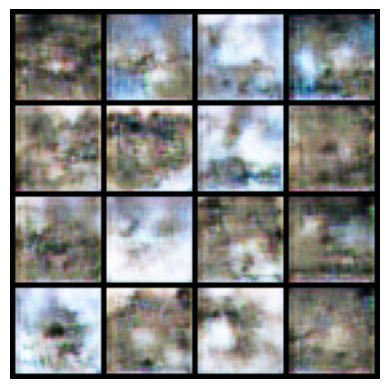

Epoch [21/100]                        Batch 100/782 Discriminator Loss: -0.0024 Generator Loss: -0.0034
Epoch [21/100]                        Batch 200/782 Discriminator Loss: 0.0175 Generator Loss: -0.0103
Epoch [21/100]                        Batch 300/782 Discriminator Loss: 0.0008 Generator Loss: 0.0199
Epoch [21/100]                        Batch 400/782 Discriminator Loss: -0.0043 Generator Loss: 0.0467
Epoch [21/100]                        Batch 500/782 Discriminator Loss: -0.0048 Generator Loss: 0.0027
Epoch [21/100]                        Batch 600/782 Discriminator Loss: 0.0054 Generator Loss: -0.0049
Epoch [21/100]                        Batch 700/782 Discriminator Loss: 0.0044 Generator Loss: -0.0085
Epoch [22/100]                        Batch 100/782 Discriminator Loss: 0.0035 Generator Loss: -0.0071
Epoch [22/100]                        Batch 200/782 Discriminator Loss: 0.0020 Generator Loss: -0.0063
Epoch [22/100]                        Batch 300/782 Discriminator Loss: -

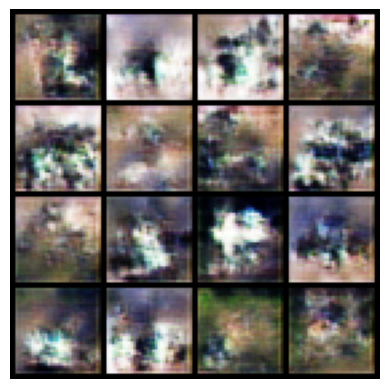

Epoch [31/100]                        Batch 100/782 Discriminator Loss: -0.0027 Generator Loss: -0.0108
Epoch [31/100]                        Batch 200/782 Discriminator Loss: -0.0023 Generator Loss: -0.0005
Epoch [31/100]                        Batch 300/782 Discriminator Loss: 0.0015 Generator Loss: 0.0108
Epoch [31/100]                        Batch 400/782 Discriminator Loss: 0.0008 Generator Loss: -0.0105
Epoch [31/100]                        Batch 500/782 Discriminator Loss: -0.0231 Generator Loss: 0.0068
Epoch [31/100]                        Batch 600/782 Discriminator Loss: 0.0091 Generator Loss: 0.0471
Epoch [31/100]                        Batch 700/782 Discriminator Loss: -0.0026 Generator Loss: 0.0097
Epoch [32/100]                        Batch 100/782 Discriminator Loss: -0.0073 Generator Loss: -0.0025
Epoch [32/100]                        Batch 200/782 Discriminator Loss: 0.0051 Generator Loss: -0.0383
Epoch [32/100]                        Batch 300/782 Discriminator Loss: 

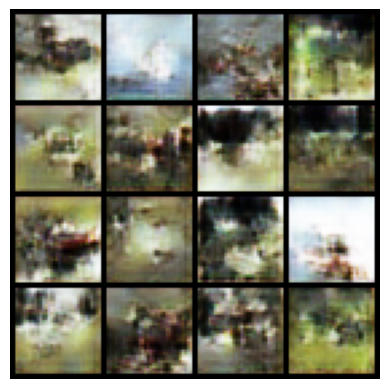

Epoch [41/100]                        Batch 100/782 Discriminator Loss: -0.0053 Generator Loss: -0.0019
Epoch [41/100]                        Batch 200/782 Discriminator Loss: -0.0021 Generator Loss: -0.0092
Epoch [41/100]                        Batch 300/782 Discriminator Loss: 0.0018 Generator Loss: -0.0097
Epoch [41/100]                        Batch 400/782 Discriminator Loss: 0.0036 Generator Loss: 0.0211
Epoch [41/100]                        Batch 500/782 Discriminator Loss: 0.0005 Generator Loss: 0.0050
Epoch [41/100]                        Batch 600/782 Discriminator Loss: -0.0080 Generator Loss: 0.0006
Epoch [41/100]                        Batch 700/782 Discriminator Loss: 0.0096 Generator Loss: 0.0095
Epoch [42/100]                        Batch 100/782 Discriminator Loss: -0.0004 Generator Loss: 0.0104
Epoch [42/100]                        Batch 200/782 Discriminator Loss: 0.0049 Generator Loss: 0.0059
Epoch [42/100]                        Batch 300/782 Discriminator Loss: -0.

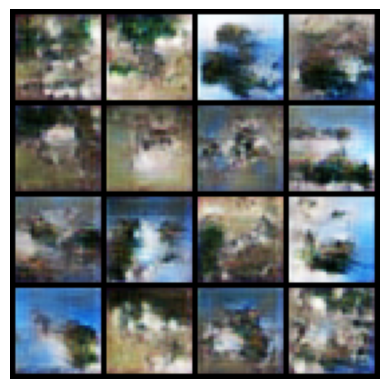

Epoch [51/100]                        Batch 100/782 Discriminator Loss: -0.0006 Generator Loss: -0.0025
Epoch [51/100]                        Batch 200/782 Discriminator Loss: 0.0043 Generator Loss: -0.0091
Epoch [51/100]                        Batch 300/782 Discriminator Loss: -0.0015 Generator Loss: 0.0074
Epoch [51/100]                        Batch 400/782 Discriminator Loss: -0.0035 Generator Loss: 0.0067
Epoch [51/100]                        Batch 500/782 Discriminator Loss: 0.0022 Generator Loss: 0.0018
Epoch [51/100]                        Batch 600/782 Discriminator Loss: 0.0036 Generator Loss: 0.0015
Epoch [51/100]                        Batch 700/782 Discriminator Loss: -0.0041 Generator Loss: -0.0016
Epoch [52/100]                        Batch 100/782 Discriminator Loss: 0.0007 Generator Loss: -0.0112
Epoch [52/100]                        Batch 200/782 Discriminator Loss: 0.0030 Generator Loss: -0.0007
Epoch [52/100]                        Batch 300/782 Discriminator Loss: 0

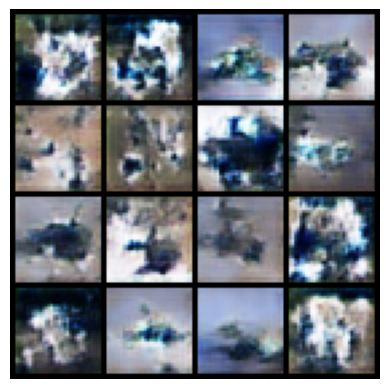

Epoch [61/100]                        Batch 100/782 Discriminator Loss: -0.0017 Generator Loss: 0.0158
Epoch [61/100]                        Batch 200/782 Discriminator Loss: -0.0071 Generator Loss: 0.0051
Epoch [61/100]                        Batch 300/782 Discriminator Loss: -0.0042 Generator Loss: 0.0143
Epoch [61/100]                        Batch 400/782 Discriminator Loss: 0.0027 Generator Loss: -0.0022
Epoch [61/100]                        Batch 500/782 Discriminator Loss: 0.0033 Generator Loss: 0.0093
Epoch [61/100]                        Batch 600/782 Discriminator Loss: -0.0030 Generator Loss: -0.0023
Epoch [61/100]                        Batch 700/782 Discriminator Loss: -0.0022 Generator Loss: 0.0019
Epoch [62/100]                        Batch 100/782 Discriminator Loss: 0.0006 Generator Loss: -0.0012
Epoch [62/100]                        Batch 200/782 Discriminator Loss: 0.0031 Generator Loss: -0.0062
Epoch [62/100]                        Batch 300/782 Discriminator Loss: -

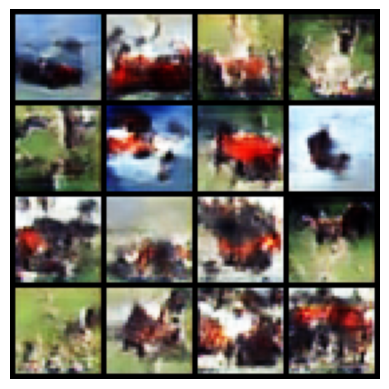

Epoch [71/100]                        Batch 100/782 Discriminator Loss: 0.0158 Generator Loss: 0.0099
Epoch [71/100]                        Batch 200/782 Discriminator Loss: -0.0031 Generator Loss: 0.0061
Epoch [71/100]                        Batch 300/782 Discriminator Loss: -0.0065 Generator Loss: -0.0038
Epoch [71/100]                        Batch 400/782 Discriminator Loss: 0.0080 Generator Loss: -0.0121
Epoch [71/100]                        Batch 500/782 Discriminator Loss: 0.0021 Generator Loss: 0.0083
Epoch [71/100]                        Batch 600/782 Discriminator Loss: -0.0106 Generator Loss: -0.0140
Epoch [71/100]                        Batch 700/782 Discriminator Loss: -0.0026 Generator Loss: -0.0003
Epoch [72/100]                        Batch 100/782 Discriminator Loss: 0.0008 Generator Loss: 0.0048
Epoch [72/100]                        Batch 200/782 Discriminator Loss: -0.0074 Generator Loss: 0.0146
Epoch [72/100]                        Batch 300/782 Discriminator Loss: 0

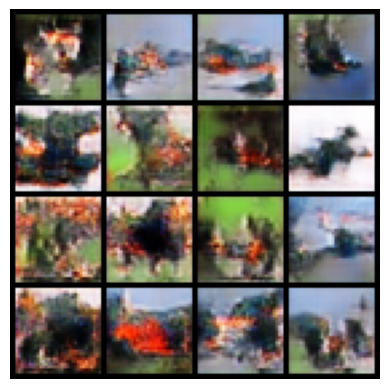

Epoch [81/100]                        Batch 100/782 Discriminator Loss: 0.0041 Generator Loss: 0.0232
Epoch [81/100]                        Batch 200/782 Discriminator Loss: -0.0066 Generator Loss: 0.0221
Epoch [81/100]                        Batch 300/782 Discriminator Loss: -0.0067 Generator Loss: -0.0198
Epoch [81/100]                        Batch 400/782 Discriminator Loss: -0.0037 Generator Loss: -0.0145
Epoch [81/100]                        Batch 500/782 Discriminator Loss: -0.0024 Generator Loss: 0.0228
Epoch [81/100]                        Batch 600/782 Discriminator Loss: 0.0059 Generator Loss: 0.0130
Epoch [81/100]                        Batch 700/782 Discriminator Loss: 0.0002 Generator Loss: -0.0071
Epoch [82/100]                        Batch 100/782 Discriminator Loss: -0.0001 Generator Loss: -0.0105
Epoch [82/100]                        Batch 200/782 Discriminator Loss: -0.0043 Generator Loss: 0.0168
Epoch [82/100]                        Batch 300/782 Discriminator Loss: 

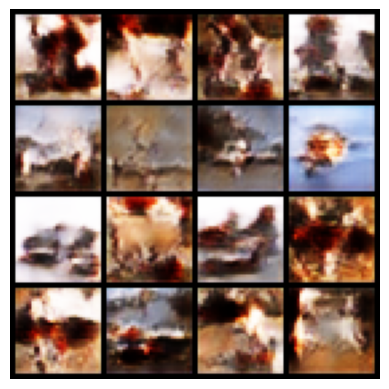

Epoch [91/100]                        Batch 100/782 Discriminator Loss: -0.0274 Generator Loss: 0.0880
Epoch [91/100]                        Batch 200/782 Discriminator Loss: 0.0301 Generator Loss: 0.0309
Epoch [91/100]                        Batch 300/782 Discriminator Loss: -0.0385 Generator Loss: -0.0274
Epoch [91/100]                        Batch 400/782 Discriminator Loss: 0.0058 Generator Loss: -0.0274
Epoch [91/100]                        Batch 500/782 Discriminator Loss: -0.0005 Generator Loss: -0.0445
Epoch [91/100]                        Batch 600/782 Discriminator Loss: 0.0021 Generator Loss: -0.0932
Epoch [91/100]                        Batch 700/782 Discriminator Loss: -0.0143 Generator Loss: -0.0008
Epoch [92/100]                        Batch 100/782 Discriminator Loss: -0.0115 Generator Loss: -0.0137
Epoch [92/100]                        Batch 200/782 Discriminator Loss: -0.0115 Generator Loss: -0.0311
Epoch [92/100]                        Batch 300/782 Discriminator Los

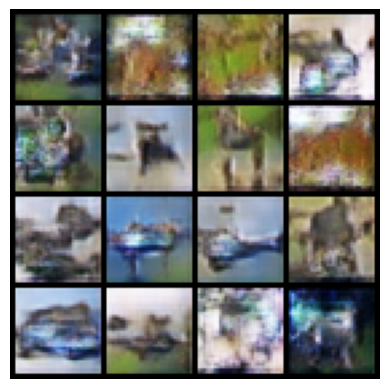

In [8]:
# Step 8: Training the GAN

# Training loop
for epoch in range(num_epochs):
    for i, batch in enumerate(dataloader):
       # Convert list to tensor
        real_images = batch[0].to(device)
        # Adversarial ground truths
        valid = torch.ones(real_images.size(0), 1, device=device)
        fake = torch.zeros(real_images.size(0), 1, device=device)
        # Configure input
        real_images = real_images.to(device)

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()
        # Sample noise as generator input
        z = torch.randn(real_images.size(0), latent_dim, device=device)
        # Generate a batch of images
        fake_images = generator(z)

        # Measure discriminator's ability
        # to classify real and fake images
        real_loss = -torch.mean(discriminator(real_images)) # for real images
        fake_loss = torch.mean(discriminator(fake_images.detach()))  # for fake images
        d_loss = real_loss + fake_loss  # Discriminator total loss


        # Backward pass and optimize
        d_loss.backward()
        optimizer_D.step()

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()
        # Generate a batch of images
        gen_images = generator(z)
        # Adversarial loss
        #g_loss = adversarial_loss(discriminator(gen_images), valid)
        g_loss = -torch.mean(discriminator(gen_images))  # Generator loss
        # Backward pass and optimize
        g_loss.backward()
        optimizer_G.step()
        # ---------------------
        #  Progress Monitoring
        # ---------------------
        if (i + 1) % 100 == 0:
            print(
                f"Epoch [{epoch+1}/{num_epochs}]\
                        Batch {i+1}/{len(dataloader)} "
                f"Discriminator Loss: {d_loss.item():.4f} "
                f"Generator Loss: {g_loss.item():.4f}"
            )
    # Save generated images for every epoch
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            z = torch.randn(16, latent_dim, device=device)
            generated = generator(z).detach().cpu()
            grid = torchvision.utils.make_grid(generated,\
                                        nrow=4, normalize=True)
            plt.imshow(np.transpose(grid, (1, 2, 0)))
            plt.axis("off")
            plt.show()